**cosine similarity-based classifier**: is a machine learning approach that uses


cosine similarity to classify data points. Instead of relying on traditional distance metrics like Euclidean distance, it measures the angle between vectors in the feature space to determine similarity. Here's how it works:

**Advantages:**

*   Robust to variations in magnitude, focusing on the direction of vectors.
*   Effective for tasks like few-shot learning, where data is limited.

**Imports**

In [34]:
import os

import pandas as pd
import numpy as np

import tarfile
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import kagglehub

import glob

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Data Processing**

In [36]:
# Download latest version
source_path = kagglehub.dataset_download("meetnagadia/human-action-recognition-har-dataset")

print("Path to dataset files:", source_path)

Path to dataset files: /kaggle/input/human-action-recognition-har-dataset


In [37]:
# Download latest version
target_path = kagglehub.dataset_download("emirhanai/human-action-detection-artificial-intelligence")

print("Path to dataset files:", target_path)

Path to dataset files: /kaggle/input/human-action-detection-artificial-intelligence


In [38]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [39]:
# walk_through_dir(source_path)

In [40]:
# walk_through_dir(target_path)

In [41]:
source_train_path = os.path.join(source_path, "Human Action Recognition/train")
source_test_path = os.path.join(source_path, "Human Action Recognition/test")

target_train_path = os.path.join(target_path, "emirhan_human_dataset/datasets/human_data/train_data")
target_test_path = os.path.join(target_path, "emirhan_human_dataset/datasets/human_data/test_data")

In [42]:
target_train_path

'/kaggle/input/human-action-detection-artificial-intelligence/emirhan_human_dataset/datasets/human_data/train_data'

In [43]:
# /kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv
# /kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv

In [44]:
def random_image_from_dir(dir_path):
    # Get all image file paths, including those in subdirectories
    image_files = []
    for root, _, files in os.walk(dir_path):
        for file in files:
            # Check for common image file extensions
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_files.append(os.path.join(root, file))

    if not image_files:
        print("No image files found in the directory.")
        return

    # Select a random image
    random_image = random.choice(image_files)

    # Load and display the image
    img = mpimg.imread(random_image)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Random Image: {os.path.basename(random_image)}")
    plt.show()

Random Source Image


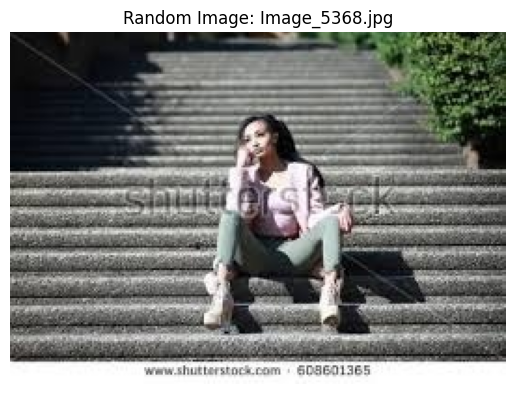

In [45]:
print('Random Source Image')
random_image_from_dir(source_train_path)

Random Target Image


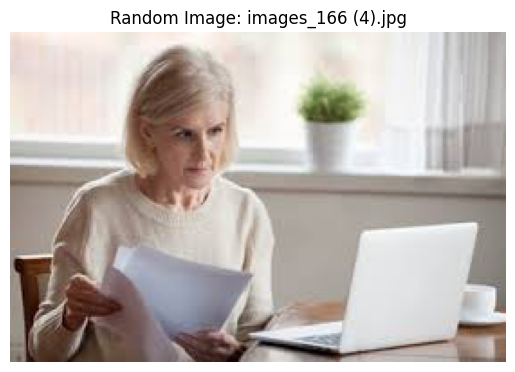

In [46]:
print('Random Target Image')
random_image_from_dir(target_train_path)

Merge the CSV File with the Train/Test Directory Images

In [47]:
train_labels_path = os.path.join(source_path, "Human Action Recognition/Training_set.csv")
train_labels = pd.read_csv(train_labels_path)
train_labels.head()

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


In [48]:
unique_labels = train_labels['label'].unique()
unique_labels

array(['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking',
       'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating',
       'fighting', 'listening_to_music', 'running', 'texting'],
      dtype=object)

In [49]:
image_files = os.listdir(source_train_path)
print(image_files[:5])

['Image_4378.jpg', 'Image_5576.jpg', 'Image_6267.jpg', 'Image_747.jpg', 'Image_8010.jpg']


In [50]:
def match_image_with_label(image_path, labels_df):
  # List all the images in the dir
  image_files = os.listdir(image_path)

  # Match each filename in the CSV with the corresponding images
  matched_data = []
  for _ , row in labels_df.iterrows():
    filename = row['filename']
    label = row['label']
    if filename in image_files:
      full_image_path = os.path.join(image_path, filename)
      matched_data.append({'filename': filename, 'label': label, 'image_path': full_image_path})

  # Convert the matched data to a DataFrame
  matched_df = pd.DataFrame(matched_data)

  return matched_df


In [51]:
train_list = match_image_with_label(source_train_path, train_labels)

train_df = pd.DataFrame(train_list)
train_df.to_csv("matched_train_data.csv", index=False)
train_df.head()


,filename,label,image_path
0,Image_1.jpg,sitting,/kaggle/input/human-action-recognition-har-dat...
1,Image_2.jpg,using_laptop,/kaggle/input/human-action-recognition-har-dat...
2,Image_3.jpg,hugging,/kaggle/input/human-action-recognition-har-dat...
3,Image_4.jpg,sleeping,/kaggle/input/human-action-recognition-har-dat...
4,Image_5.jpg,using_laptop,/kaggle/input/human-action-recognition-har-dat...


In [52]:
# transformers
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [53]:
label_mapping = {
    'calling': 0,
    'clapping': 1,
    'cycling': 2,
    'dancing': 3,
    'drinking': 4,
    'eating': 5,
    'fighting': 6,
    'hugging': 7,
    'laughing': 8,
    'listening_to_music': 9,
    'running': 10,
    'sitting': 11,
    'sleeping': 12,
    'texting': 13,
    'using_laptop': 14
}


In [54]:
#Datasets

#Custom Datasets
class HARImageDataset(torch.utils.data.Dataset):
  def __init__(self, df, transform = None, label_mapping=None):
    self.df = df
    self.transform = transform
    self.label_mapping = label_mapping

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    image_path = self.df.iloc[idx]['image_path']
    label = self.df.iloc[idx]['label']

    if self.label_mapping and isinstance(label, str):
      label = self.label_mapping[label]

    try:
        # Load the image using PIL
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image at {image_path}: {e}")
        raise ValueError(f"Failed to load data at index {idx}")

    if self.transform:
      image = self.transform(image)

    return image, torch.tensor(label, dtype=torch.long)


In [55]:
source_data = HARImageDataset(train_df, transform=simple_transform, label_mapping=label_mapping)
target_data = ImageFolder(target_train_path, transform = simple_transform)

source_dataloader = DataLoader(source_data, batch_size = 32, shuffle = True)
target_dataloader = DataLoader(target_data, batch_size = 32, shuffle = True)

In [56]:
len(source_dataloader), len(target_dataloader)

(394, 469)

In [57]:
# Example: Access first item in the dataset
image, label = source_data[0]
print(f"Source Image shape: {image.shape}, Label: {label}")

image, label = target_data[0]
print(f"Target Image Image shape: {image.shape}, Label: {label}")

Source Image shape: torch.Size([3, 224, 224]), Label: 11
Target Image Image shape: torch.Size([3, 224, 224]), Label: 0


In [58]:
type(source_dataloader)

torch.utils.data.dataloader.DataLoader

In [59]:
print("Source DataLoader")
source_img, source_label = next(iter(source_dataloader))

print(f"Image batch shape: {source_img.shape}")
print(f"Label batch shape: {len(source_label)}")
print(f"Label: {source_label}")
print('source label',{type(source_label)})


print("Target Dataloader")
target_img, target_labels = next(iter(target_dataloader))
print(f"Image shape: {target_img.shape} ")
print(f"Label shape: {len(target_labels)}")
print(f"Label: {target_labels}")
print('target label',{type(target_labels)})



Source DataLoader
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: 32
Label: tensor([ 1,  3, 13,  3,  6, 14,  9,  8,  9,  3,  1,  3,  5, 13, 13,  9, 12,  6,
         3,  0,  6,  6,  7, 14,  4,  3,  9,  7, 12,  1,  5,  4])
source label {<class 'torch.Tensor'>}
Target Dataloader
Image shape: torch.Size([32, 3, 224, 224]) 
Label shape: 32
Label: tensor([ 0, 14,  7,  0,  2, 14, 10, 11, 10,  5, 11,  5, 10,  5, 14,  6,  6, 12,
         6,  2,  2,  8,  1,  7,  6, 10, 11,  7,  6,  6,  9,  2])
target label {<class 'torch.Tensor'>}


In [60]:
# target_mapping = target_data.class_to_idx
# print(target_mapping)

# source_mapping = source_data.label_mapping
# print(source_mapping)

**Models**

In [61]:
# Load ResNet50 pretrained model and remove the classification head
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Remove the final fully connected layer

    def forward(self, x):
        features = self.resnet(x)
        return features.view(features.size(0), -1)  # Flatten the feature map


In [62]:
class CosineSimClassifier(nn.Module):
    def __init__(self, base_model, embedding_dim, num_classes):
        super(CosineSimClassifier, self).__init__()
        self.feature_extractor = base_model
        self.classification_head = nn.Linear(embedding_dim, embedding_dim, bias=False)  # Projection head
        self.class_prototypes = nn.Parameter(torch.randn(num_classes, embedding_dim))  # Learnable centroids

    def forward(self, x):
        embeddings = self.feature_extractor(x)
        embeddings = embeddings.view(embeddings.size(0), -1)  # Flatten features
        embeddings = nn.functional.normalize(embeddings, p=2, dim=1)  # Normalize embeddings
        embeddings = self.classification_head(embeddings)  # Projection

        # Compute cosine similarity between embeddings and class prototypes
        cosine_similarities = torch.mm(embeddings, self.class_prototypes.t())

        return cosine_similarities




**Training loop**

In [63]:
feature_extractor = FeatureExtractor()
model = CosineSimClassifier(feature_extractor, 2048, 15)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
def train_cosine_classifier(model, data_loader1, data_loader2, optimizer, criterion, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.to(device)
        model.train()
        total_loss = 0.0

        # Combine data from both datasets in each epoch
        for data_loader in [data_loader1, data_loader2]:
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)


                # Forward pass
                similarities = model(inputs)  # Outputs cosine similarity scores
                # print(labels.shape)
                # print(similarities.shape)
                loss = criterion(similarities, labels)  # Compute loss
                optimizer.zero_grad()

                # Backward pass
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {total_loss:.4f}")

    print("Training Completed!")


In [33]:
train_cosine_classifier(model, source_dataloader, target_dataloader, optimizer, criterion, device, num_epochs=20)

Epoch 1/20 - Loss: 2376.1615
Epoch 2/20 - Loss: 2137.1634
Epoch 3/20 - Loss: 1934.6329
Epoch 4/20 - Loss: 1909.2972
Epoch 5/20 - Loss: 1863.2425
Epoch 6/20 - Loss: 1880.4520
Epoch 7/20 - Loss: 1807.9467
Epoch 8/20 - Loss: 1596.2131
Epoch 9/20 - Loss: 1477.9648
Epoch 10/20 - Loss: 1396.4257
Epoch 11/20 - Loss: 1226.6906
Epoch 12/20 - Loss: 1051.2160
Epoch 13/20 - Loss: 863.2628
Epoch 14/20 - Loss: 705.2224
Epoch 15/20 - Loss: 474.7429
Epoch 16/20 - Loss: 401.6765
Epoch 17/20 - Loss: 325.7222
Epoch 18/20 - Loss: 268.6869
Epoch 19/20 - Loss: 191.9975
Epoch 20/20 - Loss: 180.2434
Training Completed!


**Testing Loop**

In [65]:
target_test_path = os.path.join(target_path, "emirhan_human_dataset/datasets/human_data/test_data")

target_test_data = ImageFolder(target_test_path, transform = simple_transform)
target_test_dataloader = DataLoader(target_test_data, batch_size = 32, shuffle = True)

In [66]:
def test_model(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            similarities = model(inputs)  # Outputs cosine similarity scores

            # Compute loss
            loss = criterion(similarities, labels)
            total_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(similarities, dim=1)  # Get index of highest similarity
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Compute average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4%}")
    return avg_loss, accuracy


In [69]:
# test_model(model, target_test_dataloader, criterion, device)